In [322]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import torch_dip_utils as utils
import math

import time

import pywt

env: CUDA_VISIBLE_DEVICES=0


## Net hyperparameters - mainly want to change INPUT_X lines

In [323]:
LR = 1e-4 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 500 # number iterations
WD = 1e-4 # weight decay for l2-regularization

INPUT_LEN = 8 # input len
INPUT_CHANS = 16 #number of channels in our input 

OUTPUT_CHANS = 1 #num channels in the net output
OUTPUT_LEN = 128

X_OUTPUT = np.arange(OUTPUT_LEN) #set up an axis for plotting wave outputs

In [324]:
CUDA = torch.cuda.is_available()
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


## Define single-layer topologies for input length of 1, 8, and 32 with variable input channel size

In [325]:
#INPUT_LEN = 1
#Latent size = output for input_chans = 128
class DCGAN1(nn.Module):
    def __init__(self, input_chans=32, output_chans=1):
        super(DCGAN1, self).__init__()
        self.nc = output_chans
        self.output_size = OUTPUT_LEN

        #use for multiplying input size by 128 for input_len = 1
        #For default case (32 input_chans) - higly overparameterized

        self.conv1 = nn.ConvTranspose1d(input_chans, output_chans, 128, 1, 0, bias=False) #coarse filter

    def forward(self, x):
        x = self.conv1(x)

        return x

#INPUT_LEN = 8
#Latent size = output for input_chans = 16
class DCGAN2(nn.Module):
    def __init__(self, input_chans=32, output_chans=1):
        super(DCGAN2, self).__init__()
        self.nc = output_chans
        self.output_size = OUTPUT_LEN

        #use for multiplying input size by 128 for input_len = 1
        #For default case (32 input_chans) - overparameterized

        self.conv1 = nn.ConvTranspose1d(input_chans, output_chans, 16, 16, 0, bias=False) #medium filter

    def forward(self, x):
        x = self.conv1(x)

        return x
    
#INPUT_LEN = 32
#Latent size = output for input_chans = 4
class DCGAN3(nn.Module):
    def __init__(self, input_chans=32, output_chans=1):
        super(DCGAN3, self).__init__()
        self.nc = output_chans
        self.output_size = OUTPUT_LEN

        #use for multiplying input size by 4 for input_len > 1
        #for default case (32 input_chans) - #params = output_len
        #reduce input_chans to underparameterize, increase to overparameterize

        self.conv1 = nn.ConvTranspose1d(input_chans, output_chans, 4, 4, 0, bias=False) #fine filter

    def forward(self, x):
        x = self.conv1(x)

        return x

## Set up net - nothing to change here

In [326]:
if INPUT_LEN == 1:
    net = DCGAN1(input_chans = INPUT_CHANS, output_chans = OUTPUT_CHANS)
elif INPUT_LEN == 8:
    net = DCGAN2(input_chans = INPUT_CHANS, output_chans = OUTPUT_CHANS)
elif INPUT_LEN == 32:
    net = DCGAN3(input_chans = INPUT_CHANS, output_chans = OUTPUT_CHANS)

if CUDA:
    net.cuda()
    print("USING CUDA")
else:
    print("RUNNING ON CPU")
    
allparams = [x for x in net.parameters()]

z = Variable(torch.zeros(INPUT_LEN * INPUT_CHANS).type(dtype).view(1,INPUT_CHANS,INPUT_LEN))
z.data.normal_().type(dtype)

optim = torch.optim.RMSprop(allparams,lr=LR,momentum=MOM, weight_decay=WD)

mse = torch.nn.MSELoss().type(dtype)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total net Params: ", pytorch_total_params)

print("Latent Size: ", INPUT_LEN*INPUT_CHANS)

USING CUDA
Total net Params:  256
Latent Size:  128


## Create training data - change noise_std and signal tpe

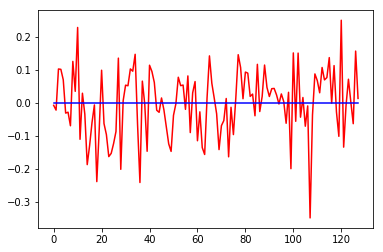

In [327]:
noise_std = 0.1
noise_mean = 0

y0 = np.zeros((OUTPUT_LEN))
#y0 = pywt.data.demo_signal(name='Ramp', n=OUTPUT_LEN)
y1 = y0.copy() + (noise_std * np.random.randn(OUTPUT_LEN)) + noise_mean

plt.figure()
plt.plot(y1, color='r')
plt.plot(y0, color='b')

## Normalize noisy training data to [-1,1] and use same parameters to normalize clean data to some range about [-1,1] - Nothing to change

In [328]:
def get_stats(x):
    a = np.min(x)
    b = np.max(x)
    mu = (a+b)/2.0
    sigma = (b-a)/2.0
    return [mu, sigma]
    #mu = np.mean(x)
    #sigma = np.std(x)
    #return [mu, sigma]

MU = get_stats(y1)[0]
SIGMA = get_stats(y1)[1]

def normalise(x):
    return (x-MU)/SIGMA

def renormalise(x):
    return x*SIGMA + MU

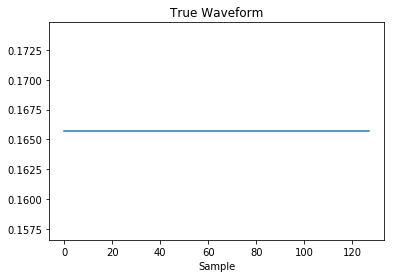

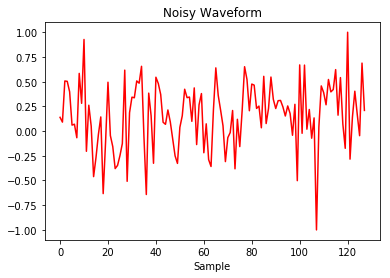

In [329]:
y0 = normalise(y0)
plt.figure()
plt.plot(X_OUTPUT, y0)
plt.xlabel("Sample")
plt.title("True Waveform")
plt.show()

y1 = normalise(y1)
plt.figure()
plt.plot(X_OUTPUT, y1, color='r')
plt.xlabel("Sample")
plt.title("Noisy Waveform")
plt.show()

In [330]:
y = torch.Tensor(y1)
y = Variable(y.type(dtype))

if CUDA:
    y = y.cuda()

499


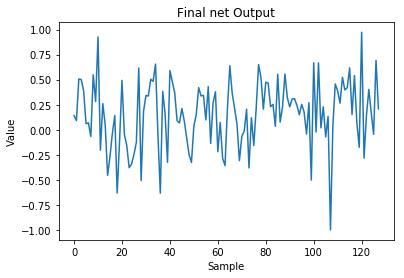

Execution Time:  0.38 s


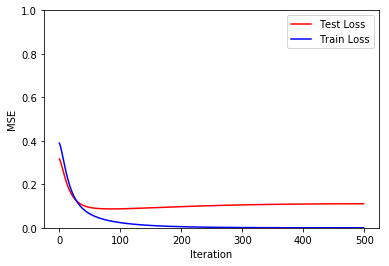

In [331]:
mse_log_true = np.zeros((NUM_ITER))
mse_log_noisy = np.zeros((NUM_ITER))

start = time.time()

for i in range(NUM_ITER):
    optim.zero_grad()
    out = net(z)
    
    loss = mse(out, y) 

    wave = out[0].detach().reshape(-1, OUTPUT_CHANS).cpu().numpy()

    mse_log_true[i] = np.mean((np.squeeze(y0) - np.squeeze(wave))**2)
    mse_log_noisy[i] = np.mean((np.squeeze(y1) - np.squeeze(wave))**2)
    
    if i == NUM_ITER - 1:
        print(i)
        
        plt.plot(X_OUTPUT, wave)
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.title("Final net Output")
        plt.show()
    
    loss.backward()
    optim.step()
    
end = time.time()
print("Execution Time: ", round(end-start, 2), "s")

plt.figure()
plt.plot(np.arange(NUM_ITER), mse_log_true, color='r', label='Test Loss')
plt.plot(np.arange(NUM_ITER), mse_log_noisy, color='b', label='Train Loss')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.ylim(0, 1)
plt.show()